## 1. Descripción del dataset

¿Por qué es importante y qué pregunta/problema pretende responder?

El objetivo es determinar las variables que impactan en el ADR (del inglés, Average Daily Room "€"). Las variables estudiadas son:

- **hotel:** Hotel (H1 = Resort Hotel or H2 = City Hotel)
- **lead_time:** Number of days that elapsed between the entering date of the booking into the PMS and the arrival date
- **arrival_date_year:** Year of arrival date
- **arrival_date_month:** Month of arrival date
- **arrival_date_week_number:** Week number of year for arrival date
- **stays_in_weekend_nights:** Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
- **stays_in_week_nights:** Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
- **country:** Country of origin. Categories are represented in the ISO 3155–3:2013 format
- **market_segment:** Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators”
- **adr:** Average Daily Rate as defined by dividing the sum of all lodging transactions by the total number of staying nights

# 2. Integración y selección de los datos

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import requests
from bs4 import BeautifulSoup as BS

In [3]:
# Leemos el dataset
data = pd.read_csv('hotel_bookings.csv')
# Comprobamos sus dimensiones
data.shape

(119390, 32)

In [4]:
# Mantenemos únicamente las variables que nos interesan
variables = [
    "hotel", "lead_time",
    "arrival_date_year", "arrival_date_month", "arrival_date_week_number",
    "stays_in_weekend_nights", "stays_in_week_nights",
    "country", "market_segment",
    "adr"
]

data = data[variables]

In [6]:
# Comprobamos sus dimensiones
data.shape

(119390, 10)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 10 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   hotel                     119390 non-null  object 
 1   lead_time                 119390 non-null  int64  
 2   arrival_date_year         119390 non-null  int64  
 3   arrival_date_month        119390 non-null  object 
 4   arrival_date_week_number  119390 non-null  int64  
 5   stays_in_weekend_nights   119390 non-null  int64  
 6   stays_in_week_nights      119390 non-null  int64  
 7   country                   118902 non-null  object 
 8   market_segment            119390 non-null  object 
 9   adr                       119390 non-null  float64
dtypes: float64(1), int64(5), object(4)
memory usage: 9.1+ MB


A simple vista, parece ser que los datos están en el formato esperado. Contamos con cuatro variables categóricas:

- **hotel:** tipo de hotel ('Resort Hotel' o 'City Hotel')
- **arrival_date_month:** mes de llegada ('January', 'February'...)
- **country:** país de origen representado en el formato ISO 3155–3:2013 ('ESP', 'USA'...)
- **market_segment:** segmento de mercado ('Direct', 'Corporate' 'Online TA'...)

y seis variables numéricas:

- **lead_time:** días de antelación para la reserva
- **arrival_date_year:** año de llegada
- **arrival_date_week_number:** semana del año de llegada
- **stays_in_weekend_nights:** noches del fin de semana (Sábado o Domingo) reservadas 
- **stays_in_week_nights:** noches de la semana (Lunes a Viernes) reservadas
- **adr:** precio medio de la noche, dividiendo el precio total por el número de noches reservadas

en total, diez variables.

# 3. Limpieza de los datos

1. ¿Los datos contienen ceros o elementos vacíos? ¿Cómo gestionarías cada uno de estos casos?
2. Identificación y tratamiento de valores extremos.

Comprobamos la existencia de valores nulos en el conjunto de datos:

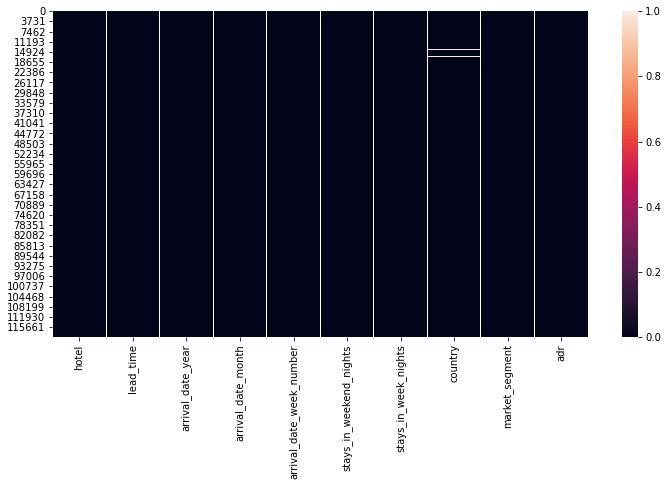

In [14]:
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull());

Observamos que algunas reservas no tienen informadas el país de origen, pero, como su número es insignificante, las eliminamos del conjunto de datos:

In [16]:
data = data.dropna()

## 3.1. Preprocesado de variables categóricas

La comprobación que hemos hecho no es suficiente para garantizar la ausencia de valores desconocidos. Estudiemos variable por variable en búsqueda de anomalías que nos sugieran que su valor es desconocido:

### **hotel**

In [40]:
list(data["hotel"].unique())

['Resort Hotel', 'City Hotel']

### **arrival_date_month**

In [39]:
sorted(data["arrival_date_month"].unique(), key = lambda m: datetime.strptime(m, "%B"))

['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

### **country**

In [88]:
countries = set(data["country"].unique())
list(data["country"].unique()[0:5])

['PRT', 'GBR', 'USA', 'ESP', 'IRL']

In [55]:
len(data["country"].unique())

177

El conjunto de datos contiene reservas de 177 países. A continuación, vamos a comprobar que todos estos están en **formato ISO 3166-1 alpha-3**, como indica el autor del *dataset*. Para ello, obtenemos la lista de Wikipedia:

In [62]:
headers = {
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,\
    */*;q=0.8",
    "Accept-Encoding": "gzip, deflate, sdch, br",
    "Accept-Language": "en-US,en;q=0.8",
    "Cache-Control": "no-cache",
    "dnt": "1",
    "Pragma": "no-cache",
    "Upgrade-Insecure-Requests": "1",
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3) AppleWebKit/5\
    37.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36"
}

url = "https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes"

response = requests.get(url, stream=True, headers=headers)

soup = BS(response.content, 'html.parser')

fields = soup.select('a[title="ISO 3166-1 alpha-3"] span')

ISO = set()

for field in fields:
    code = field.text
    ISO.add(code)

Comprobamos que todos los códigos están contenidos en la lista que obtuvimos de Wikipedia:

In [65]:
(set(ISO) & set(countries)) == set(countries)

False

In [67]:
countries - ISO

{'CN', 'TMP'}

Por un lado, 'CN' hace referencia a China, pero está en el formato ISO 3166-1 alpha-2, por lo que lo transformamos a su equivalente, 'CHN', en formato alpha-3:

In [75]:
data.loc[data["country"] == "CN", "country"] = "CHN"

Por otro, desconocemos el país al que hace referencia 'TMP', por lo que procedemos a su eliminación del conjunto de datos, no sin antes comprobar que solo un % pequeño de observaciones hacen referencia a él:

In [92]:
(data.loc[data["country"] == "TMP", "country"].count()/len(data))*100

0.0

In [87]:
data = data.drop(data.loc[data["country"] == "TMP", "country"].index)

### **market_segment**

In [90]:
list(data["market_segment"].unique())

['Direct',
 'Corporate',
 'Online TA',
 'Offline TA/TO',
 'Complementary',
 'Groups',
 'Undefined',
 'Aviation']

La variable *market_segment* tampoco se libra de los valores nulos. Comprobamos que son una parte pequeña del conjunto de datos y los eliminamos:

In [93]:
(data.loc[data["market_segment"] == "Undefined", "market_segment"].count()/len(data))*100

0.0016820999335570527

In [94]:
data = data.drop(data.loc[data["market_segment"] == "Undefined", "market_segment"].index)

## 3.2. Preprocesado de variables numéricas

### **lead_time**

In [99]:
pd.DataFrame(data["lead_time"].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
lead_time,118897.0,104.311101,106.904193,0.0,18.0,69.0,161.0,737.0


Parece raro que una reserva se haga con 737 días de antelación. Vamos a representar los valores en una caja de bigotes para identificar valores extremos:

/Users/mohammed/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


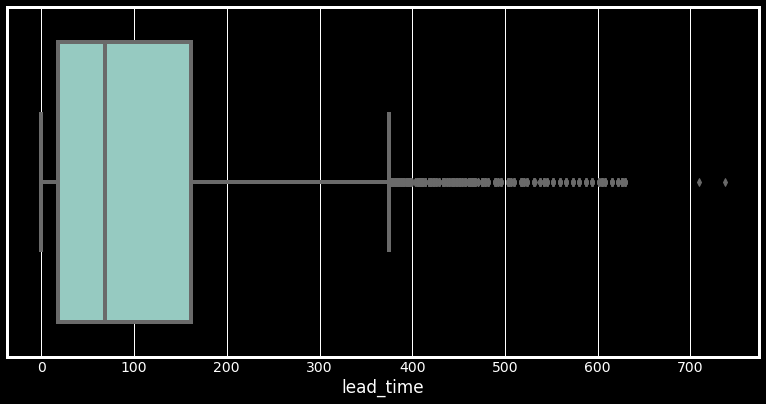

In [128]:
plt.figure(figsize=(12, 6))
plt.style.use('dark_background')

sns.boxplot(data['lead_time'])

plt.show()

Establecemos que aquellos valores que sean mayores que 1.5 veces el valor del rango intercuartil (IQR) son anómalos.

In [133]:
# ¿Cuál es el rango intercuartil de 'lead_time'?
Q1, Q3 = data['lead_time'].quantile([.25, .75])
# Rango intercuartil = Tercer cuartil - Primer cuartil
IQR = Q3 - Q1 
IQR

143.0

In [134]:
# ¿Cuántos valores anómalos tiene la variable 'lead_time'?
((data['lead_time'] < (Q1 - 1.5 * IQR)) | (data['lead_time'] > (Q3 + 1.5 * IQR))).sum()

2982

In [135]:
# ¿Cuál es el % de estos comparado con el total?
((data['lead_time'] < (Q1 - 1.5 * IQR)) | (data['lead_time'] > (Q3 + 1.5 * IQR))).sum()*100/len(data)

2.5080531888945896

### **arrival_date_year**

In [102]:
list(data["arrival_date_year"].unique())

[2015, 2016, 2017]

### **arrival_date_week_number**

In [106]:
pd.DataFrame(data["arrival_date_week_number"].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
arrival_date_week_number,118897.0,27.166262,13.589722,1.0,16.0,28.0,38.0,53.0


In [104]:
len(data["arrival_date_week_number"].unique())

53

La muestra de reservas obtenida cubre todas las semanas del año.

In [143]:
data.dtypes["arrival_date_week_number"]

dtype('int64')

Los valores de la variable está contenida en el rango [1, 53] de los números naturales, como acabamos de comprobar.

### **stays_in_weekend_nights**

In [107]:
pd.DataFrame(data["stays_in_weekend_nights"].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
stays_in_weekend_nights,118897.0,0.928888,0.996224,0.0,0.0,1.0,2.0,16.0


### **stays_in_week_nights**

In [108]:
pd.DataFrame(data["stays_in_week_nights"].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
stays_in_week_nights,118897.0,2.502183,1.90018,0.0,1.0,2.0,3.0,41.0


### **adr**

In [109]:
pd.DataFrame(data["adr"].describe()).transpose()

,count,mean,std,min,25%,50%,75%,max
adr,118897.0,102.001336,50.48609,-6.38,70.0,95.0,126.0,5400.0


# 4. Análisis de los datos

1. Selección de los grupos de datos que se quieren analizar/comparar (planificación de los análisis a aplicar).
2. Comprobación de la normalidad y homogeneidad de la varianza.
3. Aplicación de pruebas estadísticas para comparar los grupos de datos. En función de los datos y el objetivo del estudio, aplicar pruebas de contraste de hipótesis, correlaciones, regresiones, etc. Aplicar al menos tres métodos de análisis diferentes.

# 5. Visualización

Representación de los resultados a partir de tablas y gráficas.

# 6. Conclusiones

Resolución del problema. A partir de los resultados obtenidos, ¿cuáles son las conclusiones? ¿Los resultados permiten responder al problema?

the idea is to find what impact the average daily hotel room price ,either the month of the year or the distribution channel, or how early someone books the room etc..

In [45]:
#El objetivo es saber que combinacion de "lead_time","market_Segment" que se puede considerar canal de distribucion, 
#y mes / semana que resultaria en el mejor "adr" que es "average daily rate" 
# Lets read the Dataset
data = pd.read_csv('hotel_bookings.csv')

# lets check the shape of the dataset
data.shape

(119390, 32)

In [46]:
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [47]:
data.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [48]:
# quitar las columnas que no son relevantes
data = data.drop(['is_canceled',
       'arrival_date_day_of_month', 'adults', 'children', 'babies', 'meal',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'customer_type',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date','distribution_channel','days_in_waiting_list'], axis = 1)

# lets check the head of the Final Dataset
data.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,country,market_segment,adr
0,Resort Hotel,342,2015,July,27,0,0,PRT,Direct,0.0
1,Resort Hotel,737,2015,July,27,0,0,PRT,Direct,0.0
2,Resort Hotel,7,2015,July,27,0,1,GBR,Direct,75.0
3,Resort Hotel,13,2015,July,27,0,1,GBR,Corporate,75.0
4,Resort Hotel,14,2015,July,27,0,2,GBR,Online TA,98.0


In [49]:
print(data.dtypes)

hotel                        object
lead_time                     int64
arrival_date_year             int64
arrival_date_month           object
arrival_date_week_number      int64
stays_in_weekend_nights       int64
stays_in_week_nights          int64
country                      object
market_segment               object
adr                         float64
dtype: object


In [ ]:
#aqui empiezo a explorar los valores de las columnas que me interesa y determinar si hay valores que tengo que limipar

In [51]:
data.isnull().sum()

hotel                         0
lead_time                     0
arrival_date_year             0
arrival_date_month            0
arrival_date_week_number      0
stays_in_weekend_nights       0
stays_in_week_nights          0
country                     488
market_segment                0
adr                           0
dtype: int64

In [5]:
data['market_segment'].value_counts()

Online TA        56477
Offline TA/TO    24219
Groups           19811
Direct           12606
Corporate         5295
Complementary      743
Aviation           237
Undefined            2
Name: market_segment, dtype: int64

In [50]:
#tenemos dos filas con el market segment Undefined, lo kejore sera quitar estos registros porque son pocos
data.drop(data[data['market_segment']== 'Undefined'].index, inplace=True)
data.shape

(119388, 10)

In [15]:
data['arrival_date_year'].value_counts()

2016    56707
2017    40687
2015    21996
Name: arrival_date_year, dtype: int64

In [52]:
data['arrival_date_month'].value_counts()

August       13875
July         12661
May          11791
October      11160
April        11089
June         10939
September    10508
March         9794
February      8068
November      6794
December      6780
January       5929
Name: arrival_date_month, dtype: int64

In [53]:
data['arrival_date_week_number'].value_counts()

33    3580
30    3087
32    3043
34    3040
18    2926
21    2854
28    2853
17    2805
20    2785
29    2763
42    2756
31    2741
41    2699
15    2689
27    2664
25    2663
38    2661
23    2621
35    2593
39    2581
22    2546
24    2498
13    2416
16    2405
19    2402
40    2397
26    2391
43    2352
44    2272
14    2264
37    2229
8     2216
36    2167
10    2149
9     2117
7     2109
12    2083
11    2070
45    1941
53    1816
49    1782
47    1685
46    1574
6     1508
50    1505
48    1504
4     1487
5     1387
3     1319
2     1218
52    1195
1     1047
51     933
Name: arrival_date_week_number, dtype: int64

In [54]:
#derivamos una columna nueva donde se calcula la estancia total
data["total_stay"] = data["stays_in_week_nights"] + data["stays_in_weekend_nights"]
data.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,country,market_segment,adr,total_stay
0,Resort Hotel,342,2015,July,27,0,0,PRT,Direct,0.0,0
1,Resort Hotel,737,2015,July,27,0,0,PRT,Direct,0.0,0
2,Resort Hotel,7,2015,July,27,0,1,GBR,Direct,75.0,1
3,Resort Hotel,13,2015,July,27,0,1,GBR,Corporate,75.0,1
4,Resort Hotel,14,2015,July,27,0,2,GBR,Online TA,98.0,2


In [55]:
#inspeccionamos si hay valores 0 en el total de la estancia, estos valores si considereran error y hay que tratarlas
len(data[data["total_stay"] == 0].index)

715

In [56]:
#para corregir estos registros vamos a hacer replace con el mean
data['total_stay']=data['total_stay'].replace(0,int(data['total_stay'].mean()))
data.head()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,country,market_segment,adr,total_stay
0,Resort Hotel,342,2015,July,27,0,0,PRT,Direct,0.0,3
1,Resort Hotel,737,2015,July,27,0,0,PRT,Direct,0.0,3
2,Resort Hotel,7,2015,July,27,0,1,GBR,Direct,75.0,1
3,Resort Hotel,13,2015,July,27,0,1,GBR,Corporate,75.0,1
4,Resort Hotel,14,2015,July,27,0,2,GBR,Online TA,98.0,2


C:\Users\engin\anaconda3\envs\practica2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\engin\anaconda3\envs\practica2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


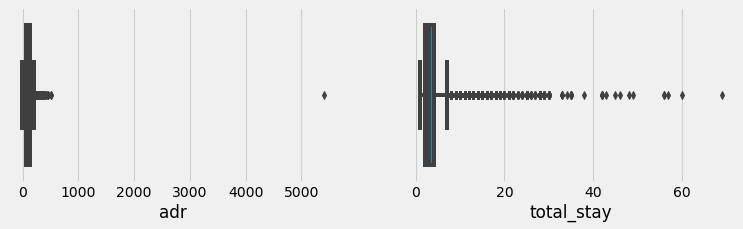

In [62]:
#exploramos si hay outliers
plt.rcParams['figure.figsize'] = (18, 3)
plt.style.use('fivethirtyeight')

plt.subplot(1, 3, 1)
sns.boxplot(data['adr'])

plt.subplot(1, 3, 2)
sns.boxplot(data['total_stay'])

plt.show()

In [63]:
#droping the outlier in adr and total stay column
data = data[data['adr'] < 1000]
data = data[data['total_stay'] < 10]

C:\Users\engin\anaconda3\envs\practica2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\engin\anaconda3\envs\practica2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


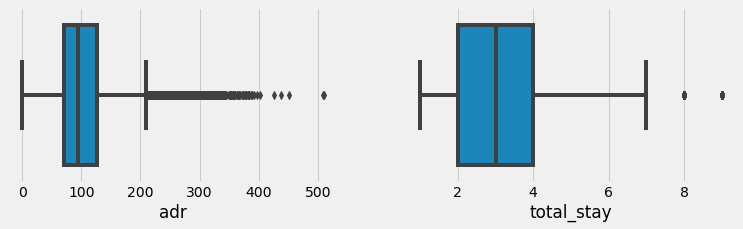

In [64]:
#exploramos si hay outliers
plt.rcParams['figure.figsize'] = (18, 3)
plt.style.use('fivethirtyeight')

plt.subplot(1, 3, 1)
sns.boxplot(data['adr'])

plt.subplot(1, 3, 2)
sns.boxplot(data['total_stay'])

plt.show()

<AxesSubplot:xlabel='total_stay', ylabel='adr'>

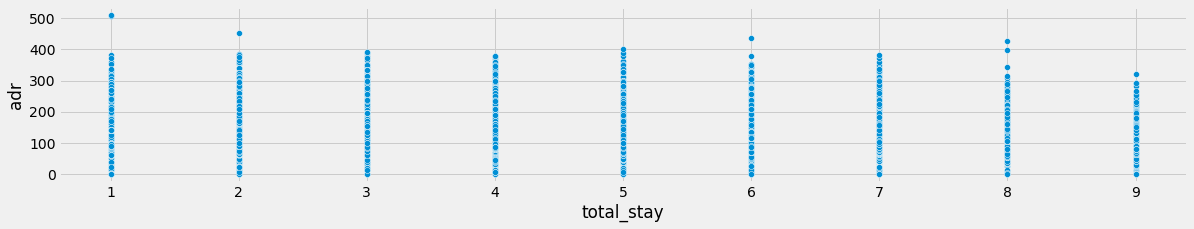

In [65]:
sns.scatterplot(data=data,x='total_stay',y='adr')

<AxesSubplot:xlabel='adr', ylabel='lead_time'>

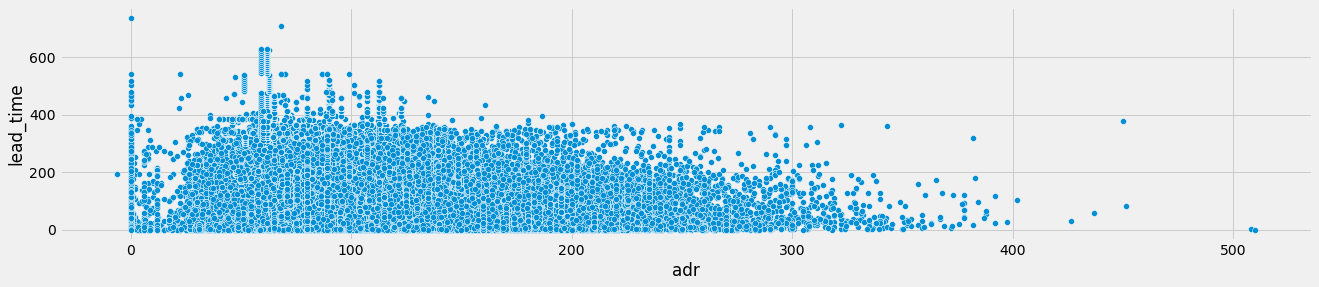

In [43]:
sns.scatterplot(data=data,x='adr',y='lead_time') #parece que no hay correlacion 

<Figure size 1440x1440 with 0 Axes>

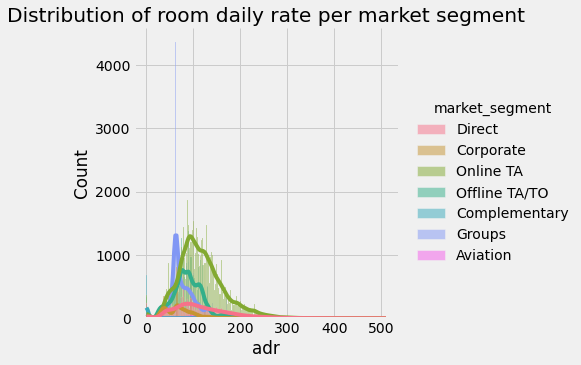

In [66]:
plt.gcf().set_size_inches(20, 20)
sns.displot(data, x="adr", hue="market_segment", kde=True)
plt.title('Distribution of room daily rate per market segment')
plt.show()

<AxesSubplot:xlabel='arrival_date_week_number', ylabel='mean_adr'>

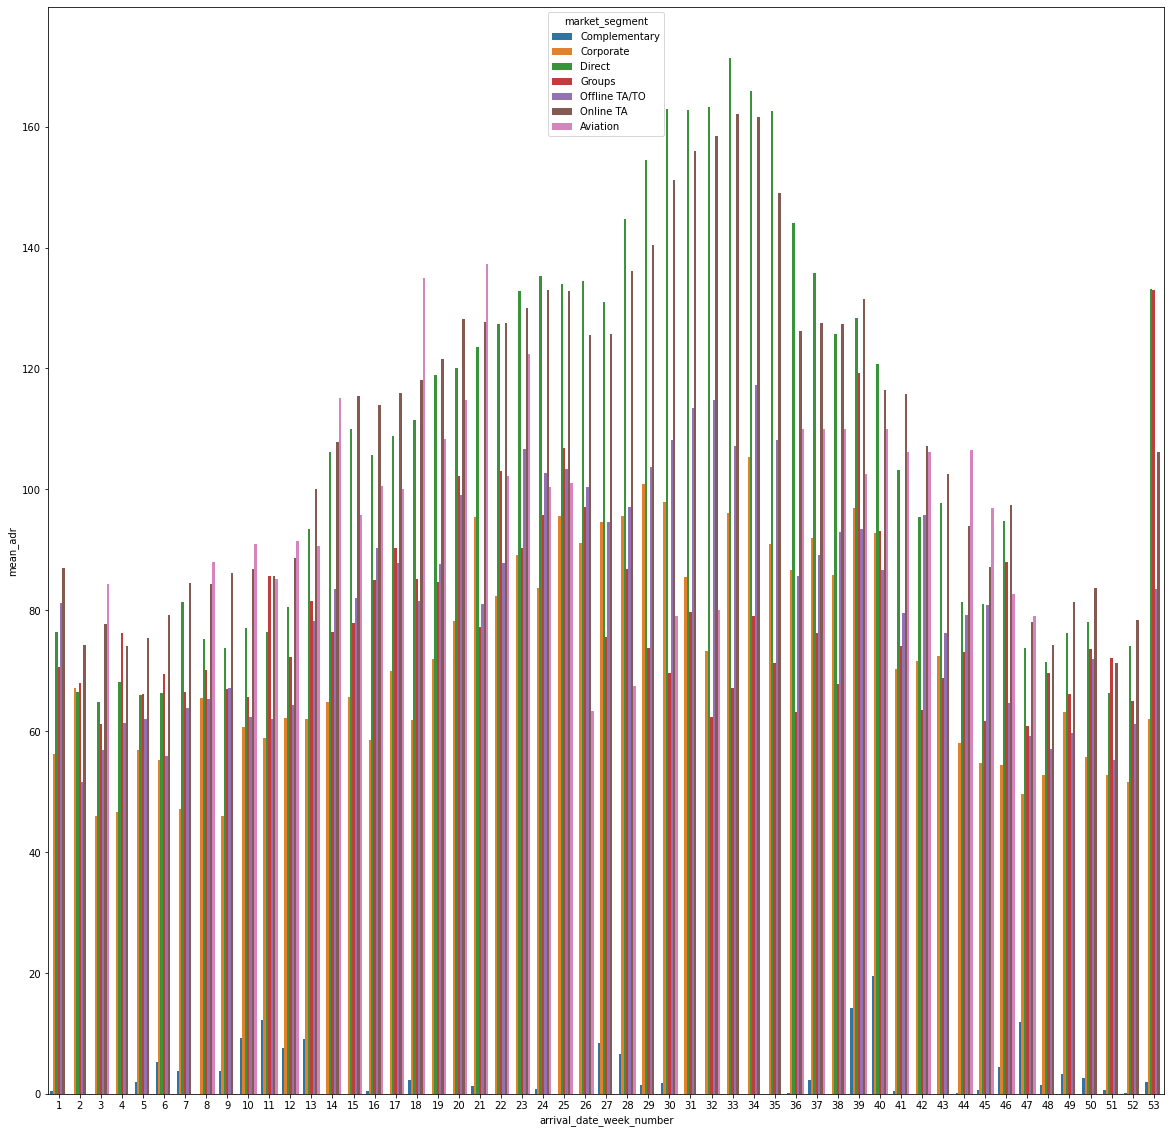

In [44]:
df = data.groupby(['arrival_date_week_number','market_segment']).agg(mean_adr=("adr", 'mean'))
df = df.reset_index()
  
# plot barplot
sns.barplot(x="arrival_date_week_number",
           y="mean_adr",hue = 'market_segment',
           data=df)